This is the third in a series of posts which constitute a "lit review" of sorts, documenting the range of methods scholars are using to compute the distribution of topics over time.

Graphs of topic prevalence over time are some of the most ubiquitous in digital humanities discussions of topic modeling. They are used as a mechanism for identifying spikes in discourse and for depicting the relationship between the various discourses in a corpus.

Topic prevalence over time is not, however, a measure that is returned with the standard modeling tools such as MALLET or Gensim. Instead, it is computed after the fact by combining the model data with external metadata and aggregating the model results. And, as it turns out, there are a number of ways that the data can be aggregated and displayed.
In this series of notebooks, I am looking at 4 different strategies for computing topic significance over time. These strategies are:

+ [Average of topic weights per year (First Post)](http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/)
+ [Smoothing or regression analysis (Second Post)](http://jeriwieringa.com/2017/06/23/calculating-and-visualizing-topic-significance-over-time-part-2/)
+ [Prevalence of the top topic per year (Third Post)](http://jeriwieringa.com/2017/06/23/calculating-and-visualizing-topic-significance-over-time-part-3/)
+ Proportion of total weights per year


To explore a range of strategies for computing and visualizing topics over time from a standard LDA model, I am using a model I created from my dissertation materials. You can download the files needed to follow along from [ https://www.dropbox.com/s/9uf6kzkm1t12v6x/2017-06-21.zip?dl=0]( https://www.dropbox.com/s/9uf6kzkm1t12v6x/2017-06-21.zip?dl=0).

If you cloned the notebook from the earlier posts, please pull down the latest version and update your environment. I forgot to add a few libraries that are needed to run these notebooks.

In [1]:
# Load the necessary libraries
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd # Note: I am running 0.19.2
import seaborn as sns

In [2]:
# Enable in-notebook visualizations
%matplotlib inline

In [3]:
pd.options.display.max_rows = 10

In [4]:
base_dir = "/Users/jeriwieringa/Dissertation/drafts/data/module-3/"
period = '1859-to-1875'
directory = "historical_periods"

# Create the dataframes

I preprocessed the model to export various aspects of the model information into CSV files for ease of compiling. I will be releasing the code I used to export that information in a later notebook. 

In [5]:
metadata_filename = os.path.join(base_dir,'2017-05-corpus-stats/2017-05-Composite-OCR-statistics.csv')
index_filename = os.path.join(base_dir, 'corpora', directory, '{}.txt'.format(period))
labels_filename = os.path.join(base_dir, 'dataframes', directory, '{}_topicLabels.csv'.format(period))
doc_topic_filename = os.path.join(base_dir, 'dataframes', directory, '{}_dtm.csv'.format(period))

In [6]:
def doc_list(index_filename):
    """
    Read in from a json document with index position and filename. 
    File was created during the creation of the corpus (.mm) file to document
    the filename for each file as it was processed.
    
    Returns the index information as a dataframe.
    """
    with open(index_filename) as data_file:    
        data = json.load(data_file)
    docs = pd.DataFrame.from_dict(data, orient='index').reset_index()
    docs.columns = ['index_pos', 'doc_id']
    docs['index_pos'] = docs['index_pos'].astype(int)
  
    return docs


def compile_dataframe( index, dtm, labels, metadata):
    """
    Combines a series of dataframes to create a large composit dataframe.
    """
    doc2metadata = index.merge(metadata, on='doc_id', how="left")
    topics_expanded = dtm.merge(labels, on='topic_id')
    
    df = topics_expanded.merge(doc2metadata, on="index_pos", how="left")
    
    return df

In [7]:
order = ['conference, committee, report, president, secretary, resolved',
         'quarterly, district, society, send, sept, business',
         'association, publishing, chart, dollar, xxii, sign',
         'mother, wife, told, went, young, school',
         'disease, physician, tobacco, patient, poison, medicine',
         'wicked, immortality, righteous, adam, flesh, hell',
        ]

In [8]:
def create_plotpoint(df, y_value, hue=None, order=order, col=None, wrap=None, size=6, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

In [9]:
metadata = pd.read_csv(metadata_filename, usecols=['doc_id', 'year','title'])
docs_index = doc_list(index_filename)
dt = pd.read_csv(doc_topic_filename)
labels = pd.read_csv(labels_filename)

The first step, following the pattern of [Andrew Goldstone for his topic model browser](https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R#L373-L415), is to normalize the weights for each document, so that they total to "1".

As a note, Goldstone first smooths the weights by adding the alpha hyperparameter to each of the weights, which I am not doing here.

In [10]:
# Reorient from long to wide
dtm = dt.pivot(index='index_pos', columns='topic_id', values='topic_weight').fillna(0)

# Divide each value in a row by the sum of the row to normalize the values
# Since last week I have found a cleaner way to normalize the rows.
# https://stackoverflow.com/questions/18594469/normalizing-a-pandas-dataframe-by-row
dtm = dtm.div(dtm.sum(axis=1), axis=0)

# Shift back to a long dataframe
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['index_pos', 'topic_id', 'norm_topic_weight']

In [11]:
df = compile_dataframe(docs_index, dt_norm, labels, metadata)

In [12]:
df

,index_pos,topic_id,norm_topic_weight,topic_words,doc_id,year,title
0,0,0,0.045525,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page1.txt,1863,GCB
1,1,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page2.txt,1863,GCB
2,2,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page3.txt,1863,GCB
3,3,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page4.txt,1863,GCB
4,4,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page5.txt,1863,GCB
...,...,...,...,...,...,...,...
288595,11539,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page4.txt,1872,YI
288596,11540,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page5.txt,1872,YI
288597,11541,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page6.txt,1872,YI
288598,11542,24,0.012192,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page7.txt,1872,YI


# Data dictionary:

+ `index_pos` : Gensim uses the order in which the docs were streamed to link back the data and the source file. `index_pos` refers to the index id for the individual doc, which I used to link the resulting model information with the document name.
+ `topic_id` : The numerical id for each topic. For this model, I used 20 topics to classify the periodical pages.
+ `norm_topic_weight` : The proportion of the tokens in the document that are part of the topic, normalized per doc.
+ `topic_words` : The top 6 words in the topic.
+ `doc_id` : The file name of the document. The filename contains metadata information about the document, such as the periodical title, date of publication, volume, issue, and page number.
+ `year` : Year the document was published (according to the filename)
+ `title` : Periodical that the page was published in.

# Computing Topic Prevalence

The third approach I found for calculating topic significance over time is computing the topic prevalence. The primary example I found of this approach is Adrien Guille's TOM, [TOpic Modeling](http://mediamining.univ-lyon2.fr/people/guille/tom.php#about), library for Python. Rather than averaging the weights, his approach is to set a baseline for determining whether a topic is significantly present (in this case, it is the topic with the highest weight for a document) and then computing the percentage of documents in a given year where the topic is significantly present. 

Following the [pattern in the TOM library](https://github.com/AdrienGuille/TOM/blob/master/tom_lib/nlp/topic_model.py#L167-L183), we can compute the prevalence of the topics by identifying the topic with the highest weight per document, grouping the results by year, adding up the number of top occurrences of each topic per year and dividing by the total number of documents per year.

In [13]:
# Group by document and take the row with max topic weight for each document
max_df = df[df.groupby(['index_pos'])['norm_topic_weight'].transform(max) == df['norm_topic_weight']]

# Group by year and topic, counting the number of documents per topic per year.
max_counts = max_df[['doc_id', 'year', 'topic_id']].groupby(['year', 'topic_id']).agg({'doc_id' : 'count'}).reset_index()
max_counts.columns = ['year', 'topic_id', 'max_count']

In [14]:
# Count the number of individual documents per year
total_docs = max_df[['year', 'doc_id']].groupby('year').agg({'doc_id' : 'count'}).reset_index()
total_docs.columns = ['year', 'total_docs']

In [15]:
# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='year', how='left')

# Create a new column with the count per topic divided by the total docs per year
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']

# Add the topic labels to make human-readable
max_counts = max_counts.merge(labels, on="topic_id")

In [16]:
max_counts

,year,topic_id,max_count,total_docs,prevalence,topic_words
0,1859,0,90,512,0.175781,"satan, salvation, sinner, righteousness, peace..."
1,1860,0,79,512,0.154297,"satan, salvation, sinner, righteousness, peace..."
2,1861,0,79,408,0.193627,"satan, salvation, sinner, righteousness, peace..."
3,1862,0,67,514,0.130350,"satan, salvation, sinner, righteousness, peace..."
4,1863,0,59,424,0.139151,"satan, salvation, sinner, righteousness, peace..."
...,...,...,...,...,...,...
352,1867,2,1,951,0.001052,"animal, fruit, horse, flesh, sheep, gardner"
353,1872,2,7,904,0.007743,"animal, fruit, horse, flesh, sheep, gardner"
354,1874,2,3,883,0.003398,"animal, fruit, horse, flesh, sheep, gardner"
355,1869,16,3,682,0.004399,"association, publishing, chart, dollar, xxii, ..."


In [17]:
# Limit to our 5 test topics
mc_s = max_counts[(max_counts['topic_id'] >= 15) & (max_counts['topic_id'] <= 20)]

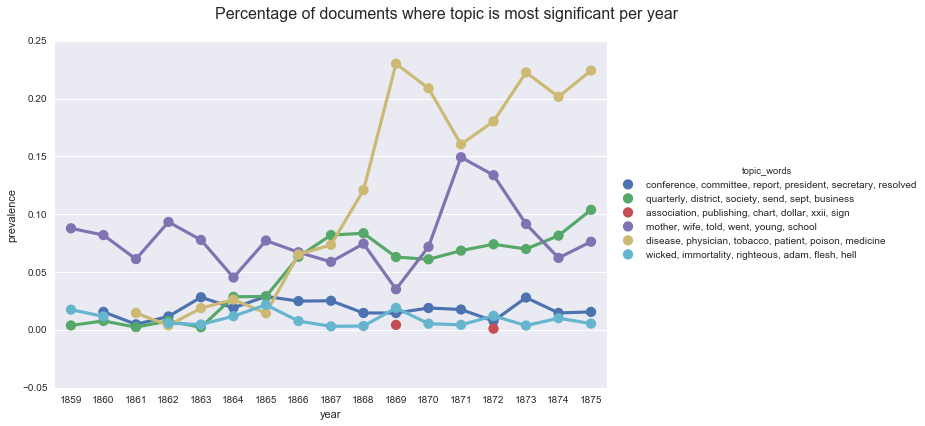

In [18]:
create_plotpoint(mc_s, 'prevalence', hue='topic_words',
                 title='Percentage of documents where topic is most significant per year'
                )

If we look back at our chart of the average topic weights per year, we can see that the two sets of lines are similar, but not the same. If we rely on prevalence, we see a larger spike of interest in health in 1867, in terms of pages dedicated to the topic. We also see more dramatic spikes in our topic on "mother, wife, told, went, young, school." 

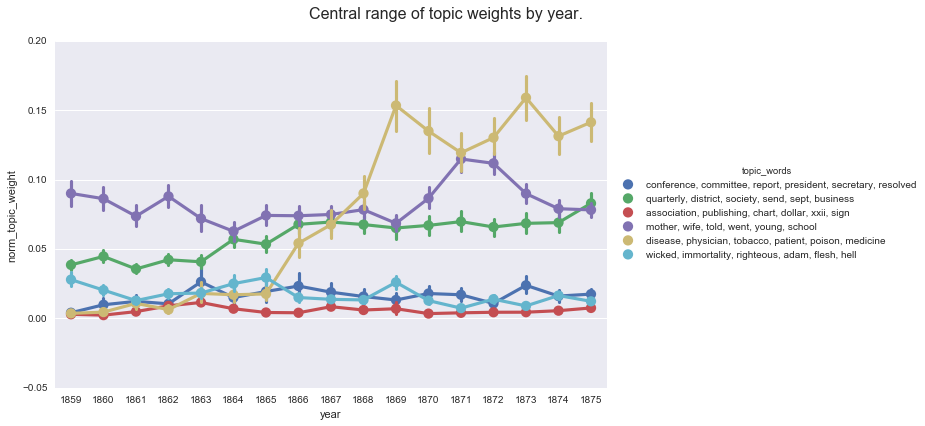

In [19]:
create_plotpoint(df, 'norm_topic_weight', hue='topic_words',
                 title='Central range of topic weights by year.'
                )

While not apparent from the data discussed here, the spikes in "mother, wife, told, went, young, school" correspond with the years where *The Youth's Instructor* is part of the corpus (1859, 1860, 1862, 1870, 1871, 1872). While the topic is clearly capturing language that occurs in multiple publications, the presence or absence of the title has a noticeable effect. We can use smoothing to adjust for the missing data (if we're interested in the overall trajectory of the topic), or use the information to frame our exploration what the topic is capturing.